In [9]:
import robustbench
from robustbench.utils import load_model
from tqdm import tqdm
import os
import torch
from autoattack import AutoAttack
from robustbench.data import _load_dataset
from torchvision import transforms, datasets
import robustbench
import matplotlib.pyplot as plt
from robustbench.utils import load_model
import torchvision
import os
import torch
import multiprocessing as mp
import pandas as pd
import sys
sys.path.append("/gavrikov/pytorch-pretrained-cnns")
import data
import models
import numpy as np
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import ImageGrid


In [3]:
testset = torchvision.datasets.CIFAR10(root='/data/datasets/cifar10', train=False, download=True, transform=torchvision.transforms.ToTensor())

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=16,
)

x_test, y_test = _load_dataset(testset)

Files already downloaded and verified


In [4]:
x_sample = x_test[0].unsqueeze(dim=0)
x_sample.shape

torch.Size([1, 3, 32, 32])

In [5]:
x_adv = torch.tensor(np.load("x_adv_linf8_255.npy"))
x_adv.shape

torch.Size([1, 3, 32, 32])

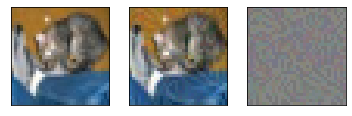

In [195]:
fig, ax = plt.subplots(1, 3,)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
ax[0].imshow(x_sample.detach().squeeze().numpy().transpose(1, 2, 0))
ax[1].imshow(x_adv.detach().squeeze().numpy().transpose(1, 2, 0))
ax[2].imshow((x_sample - x_adv).detach().squeeze().numpy().transpose(1, 2, 0) + 0.5)

plt.savefig("/gavrikov/cvpr22w_RobustnessThroughTheLense/plots/sample_vs_perturbed_sample_linf_8_255.pdf", bbox_inches='tight')

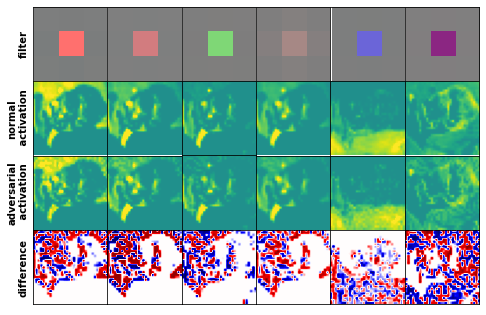

In [32]:
from skimage.transform import rescale, resize, downscale_local_mean
model = load_model(model_name="Addepalli2021Towards_WRN34", dataset="cifar10", threat_model="Linf").cuda().eval()

with torch.no_grad():
    inp = torch.concat([x_sample, x_adv]).cuda()
    mu = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).cuda()
    sigma = torch.tensor([0.2471, 0.2435, 0.2616]).view(1, 3, 1, 1).cuda()
    x = (inp - mu) / sigma
    activations = F.relu(model.conv1(x)).detach().cpu().numpy()

w = model.conv1.weight.detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(8, 6), facecolor="white")
grid = ImageGrid(fig, 111, nrows_ncols=(4, 6), axes_pad=0.0)

for ax, f in zip(grid, w[5:11]):
    ax.set_xticks([])
    ax.set_yticks([])
    f = 0.5+0.5*f/np.abs(w).max()  
    ax.imshow(f, vmin=0, vmax=1, extent=(0,32,0,32))

for ax, activation in zip(grid[6:12], activations[0].reshape(-1, 32, 32)[5:11]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow((activation.squeeze() + 1) / 2, vmin=0, vmax=1, cmap="viridis")
    
for ax, activation in zip(grid[12:18], activations[1].reshape(-1, 32, 32)[5:11]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow((activation.squeeze() + 1) / 2, vmin=0, vmax=1, cmap="viridis")
    
for ax, activation in zip(grid[18:], (activations[0][5:11]-activations[1][5:11]).reshape(-1, 32, 32)):
    ax.set_xticks([])
    ax.set_yticks([])
    t = np.abs(activation).max()
    ax.imshow(activation.squeeze(), vmin=-t, vmax=t, cmap="seismic")    
    

grid[0].set_ylabel("filter", fontsize = 10, fontweight ='bold')
grid[6].set_ylabel("normal\n activation", fontsize = 10, fontweight ='bold')
grid[12].set_ylabel("adversarial\n activation", fontsize = 10, fontweight ='bold')
grid[18].set_ylabel("difference", fontsize = 10, fontweight ='bold')
    
plt.savefig("/gavrikov/cvpr22w_RobustnessThroughTheLense/plots/primary_thresholding.pdf", bbox_inches='tight')

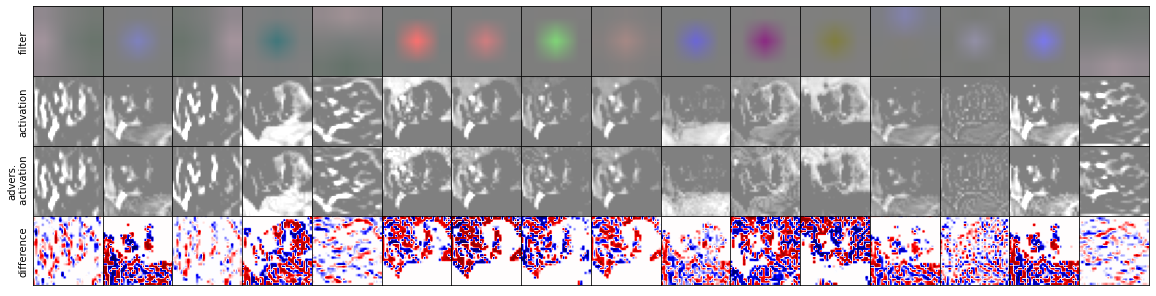

In [192]:
from skimage.transform import rescale, resize, downscale_local_mean
model = load_model(model_name="Addepalli2021Towards_WRN34", dataset="cifar10", threat_model="Linf").cuda().eval()

with torch.no_grad():
    inp = torch.concat([x_sample, x_adv]).cuda()
    mu = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).cuda()
    sigma = torch.tensor([0.2471, 0.2435, 0.2616]).view(1, 3, 1, 1).cuda()
    x = (inp - mu) / sigma
    activations = F.relu(model.conv1(x)).detach().cpu().numpy()

w = model.conv1.weight.detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(20, 8), facecolor="white")
grid = ImageGrid(fig, 111, nrows_ncols=(activations.shape[0]+2, activations.shape[1]), axes_pad=0.0)

for ax, f in zip(grid, w):
    ax.set_xticks([])
    ax.set_yticks([])
    f = 0.5+0.5*f/np.abs(w).max()  
    ax.imshow(resize(f, (32, 32), anti_aliasing=False, anti_aliasing_sigma=0, mode="edge"), vmin=0, vmax=1)

for ax, activation in zip(grid[16:48], activations.reshape(-1, 32, 32)):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow((activation.squeeze() + 1) / 2, vmin=0, vmax=1, cmap="gray")
    
for ax, activation in zip(grid[48:], (activations[0]-activations[1]).reshape(-1, 32, 32)):
    ax.set_xticks([])
    ax.set_yticks([])
    t = np.abs(activation).max()
    ax.imshow(activation.squeeze(), vmin=-t, vmax=t, cmap="seismic")    
    

grid[0].set_ylabel("filter")
grid[16].set_ylabel("activation")
grid[32].set_ylabel("advers.\n activation")
grid[48].set_ylabel("difference")
    
plt.savefig("/gavrikov/cvpr22w_RobustnessThroughTheLense/plots/activation_robust_model_Addepalli2021Towards_WRN34.pdf", bbox_inches='tight')

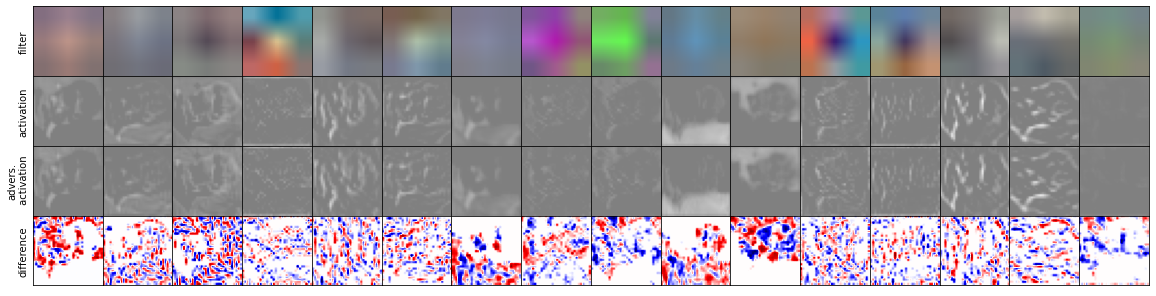

In [185]:
from skimage.transform import rescale, resize, downscale_local_mean
model = load_model(model_name="Addepalli2021Towards_WRN34", dataset="cifar10", threat_model="Linf").cuda().eval()

state = torch.load("/ssd1/checkpoints_robustbench_models_normal_training/cifar10/robustbench_Addepalli2021Towards_WRN34/version_0/checkpoints/epoch=74-step=14624.ckpt")
model.load_state_dict(dict((key.replace("model.", ""), value) for (key, value) in
                                         state["state_dict"].items()))

with torch.no_grad():
    inp = torch.concat([x_sample, x_adv]).cuda()
    mu = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).cuda()
    sigma = torch.tensor([0.2471, 0.2435, 0.2616]).view(1, 3, 1, 1).cuda()
    x = (inp - mu) / sigma
    activations = F.relu(model.conv1(x)).detach().cpu().numpy()

w = model.conv1.weight.detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(20, 8), facecolor="white")
grid = ImageGrid(fig, 111, nrows_ncols=(activations.shape[0]+2, activations.shape[1]), axes_pad=0.0)

for ax, f in zip(grid, w):
    ax.set_xticks([])
    ax.set_yticks([])
    f = 0.5+0.5*f/np.abs(w).max()  
    ax.imshow(resize(f, (32, 32), anti_aliasing=False, anti_aliasing_sigma=0, mode="edge"), vmin=0, vmax=1)

for ax, activation in zip(grid[16:48], activations.reshape(-1, 32, 32)):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow((activation.squeeze() + 1) / 2, vmin=0, vmax=1, cmap="gray")
    
for ax, activation in zip(grid[48:], (activations[0]-activations[1]).reshape(-1, 32, 32)):
    ax.set_xticks([])
    ax.set_yticks([])
    t = np.abs(activation).max()
    ax.imshow(activation.squeeze(), vmin=-t, vmax=t, cmap="seismic")    
    

grid[0].set_ylabel("filter")
grid[16].set_ylabel("activation")
grid[32].set_ylabel("advers.\n activation")
grid[48].set_ylabel("difference")
    

plt.savefig("/gavrikov/cvpr22w_RobustnessThroughTheLense/plots/activation_normal_model_Addepalli2021Towards_WRN34.pdf", bbox_inches='tight')